In [1]:
using FourierFlows
using CairoMakie
using AbstractFFTs
using Interpolations

In [2]:
function generate_amp_phase(k0, k1)
    indices = [(k, l) for k=-k1:k1, l=-k1:k1 if k0^2 <= k^2 + l^2 <= k1^2]
    N_waves = length(indices)
    amp = randn(N_waves) / N_waves
    phase_shift = 2*π*rand(N_waves)
    return amp, phase_shift, indices
end

function field_func(amp, phase_shift, indices, func)
    function field(x, y)
        ψ = 0
        for i=1:length(indices)
            k, l = indices[i]
            ψ += amp[i] * func(k, l, k*x + l*y + phase_shift[i])
        end
        return ψ
    end
    return field
end

k0 = 12
k1 = 25
amp, phase_shift, indices = generate_amp_phase(k0, k1)
ψ_func = field_func(amp, phase_shift, indices, (k, l, phase) -> cos(phase))
U_func = field_func(amp, phase_shift, indices, (k, l, phase) ->  l * sin(phase))
V_func = field_func(amp, phase_shift, indices, (k, l, phase) -> -k * sin(phase))
Ux_func = field_func(amp, phase_shift, indices, (k, l, phase) ->  l*k * cos(phase))
Uy_func = field_func(amp, phase_shift, indices, (k, l, phase) ->  l*l * cos(phase))
Vx_func = field_func(amp, phase_shift, indices, (k, l, phase) -> -k*k * cos(phase))
Vy_func = field_func(amp, phase_shift, indices, (k, l, phase) -> -k*l * cos(phase))

(::var"#field#7"{Vector{Float64}, Vector{Float64}, Vector{Tuple{Int64, Int64}}, var"#20#21"}) (generic function with 1 method)

In [3]:
grid = TwoDGrid(CPU(), Lx=2π, nx=128)
ψ = ψ_func.(grid.x, grid.y')
U = U_func.(grid.x, grid.y')
V = V_func.(grid.x, grid.y')
Ux = Ux_func.(grid.x, grid.y')
Uy = Uy_func.(grid.x, grid.y')
Vx = Vx_func.(grid.x, grid.y')
Vy = Vy_func.(grid.x, grid.y')

#heatmap(grid.x, grid.y, abs2.(U))
#Uh = fft(U)
#heatmap(grid.kr[:], fftshift(grid.l[:]), fftshift(log.(abs2.(Uh))))

128×128 Matrix{Float64}:
  3.1836      3.10528    1.64434   …  -1.30115     0.155245    1.91692
  4.97375     4.23839    0.484625     -3.28675    -0.873289    2.60127
  4.13517     3.76082   -0.18665      -4.32222    -2.47755     1.17769
  1.30398     2.15058    0.163162     -3.29343    -3.4246     -1.3731
 -1.89089     0.186977   1.08799      -0.0359983  -2.5877     -3.31259
 -4.01799    -1.42031    1.84061   …   3.85414    -0.292145   -3.67319
 -4.52057    -2.21478    2.06229       5.87601     1.81905    -2.77925
 -3.6217     -2.10515    1.7858        4.61606     2.30146    -1.51624
 -1.90523    -1.42609    1.00574       0.989924    1.2057     -0.383541
 -0.0343348  -0.783807  -0.419092     -2.52436    -0.153822    0.664372
  1.37322    -0.62838   -2.29653   …  -3.9283     -0.588493    1.67471
  1.91894    -0.85619   -3.72007      -3.0745     -0.0597539   2.31822
  1.62906    -0.888514  -3.52788      -1.24375     0.616968    2.18232
  ⋮                                ⋱   ⋮           

In [123]:
function interpolator(field, x, y)
    # return cubic_spline_interpolation((grid.x, grid.y), field, extrapolation_bc = Periodic());
    return extrapolate(
            scale(
                interpolate(field, BSpline(Cubic(Periodic(OnCell())))), 
            x, y), 
        Periodic());
end

u_itp = interpolator(U, grid.x, grid.y)
v_itp = interpolator(V, grid.x, grid.y)
ux_itp = interpolator(Ux, grid.x, grid.y)
vx_itp = interpolator(Vx, grid.x, grid.y)
uy_itp = interpolator(Uy, grid.x, grid.y)
vy_itp = interpolator(Vy, grid.x, grid.y)
println(uy_itp(0., 0.))
println((u_itp(0.000, 0.001) - u_itp(-0.000, -0.001))/0.002)

-6.566351413287709
-6.516863351730781


In [124]:
#l_itp = extrapolate(interpolate(U, Lanczos(4)), Periodic())
l_itp = extrapolate(interpolate(ψ_field, Lanczos(6)), Periodic())
func(x, y) = l_itp(mod(x + grid.Lx/2, grid.Lx)/grid.Ly * grid.nx + 1, mod(y + grid.Lx/2, grid.Ly)/grid.Ly * grid.ny + 1)
func(1.1, 1.1)

-0.011303853966470507

In [125]:
ψ_field = ψ_func.(grid.x, grid.y')
ψ_itp = interpolator(ψ_field, grid.x, grid.y)

128×128 extrapolate(scale(interpolate(::Matrix{Float64}, BSpline(Cubic(Periodic(OnCell())))), (-3.141592653589793:0.04908738521234052:3.0925052683774528, -3.141592653589793:0.04908738521234052:3.0925052683774528)), Periodic()) with element type Float64:
  0.00550344  -0.00441052  -0.0101163   …   0.012676     0.0127841
  0.0071024    0.00746879   0.00796287      0.00326424   0.00594894
  0.00299574   0.0148741    0.0209001      -0.00991609  -0.00686058
 -0.00785716   0.0117758    0.0218508      -0.0203402   -0.0213326
 -0.0186032    0.00236224   0.0150093      -0.0204294   -0.0286213
 -0.0204206   -0.00415271   0.0097525   …  -0.0069724   -0.0218232
 -0.0121253   -0.00403295   0.010053        0.014685    -0.00347008
 -0.00286228  -0.0032151    0.0104473       0.032356     0.0141472
 -0.00365564  -0.010165     0.00287798      0.0353239    0.0183149
 -0.0156379   -0.0249173   -0.0129984       0.0232903    0.0073473
 -0.0275224   -0.0367101   -0.0274681   …   0.00746127  -0.0071962
 -0.02

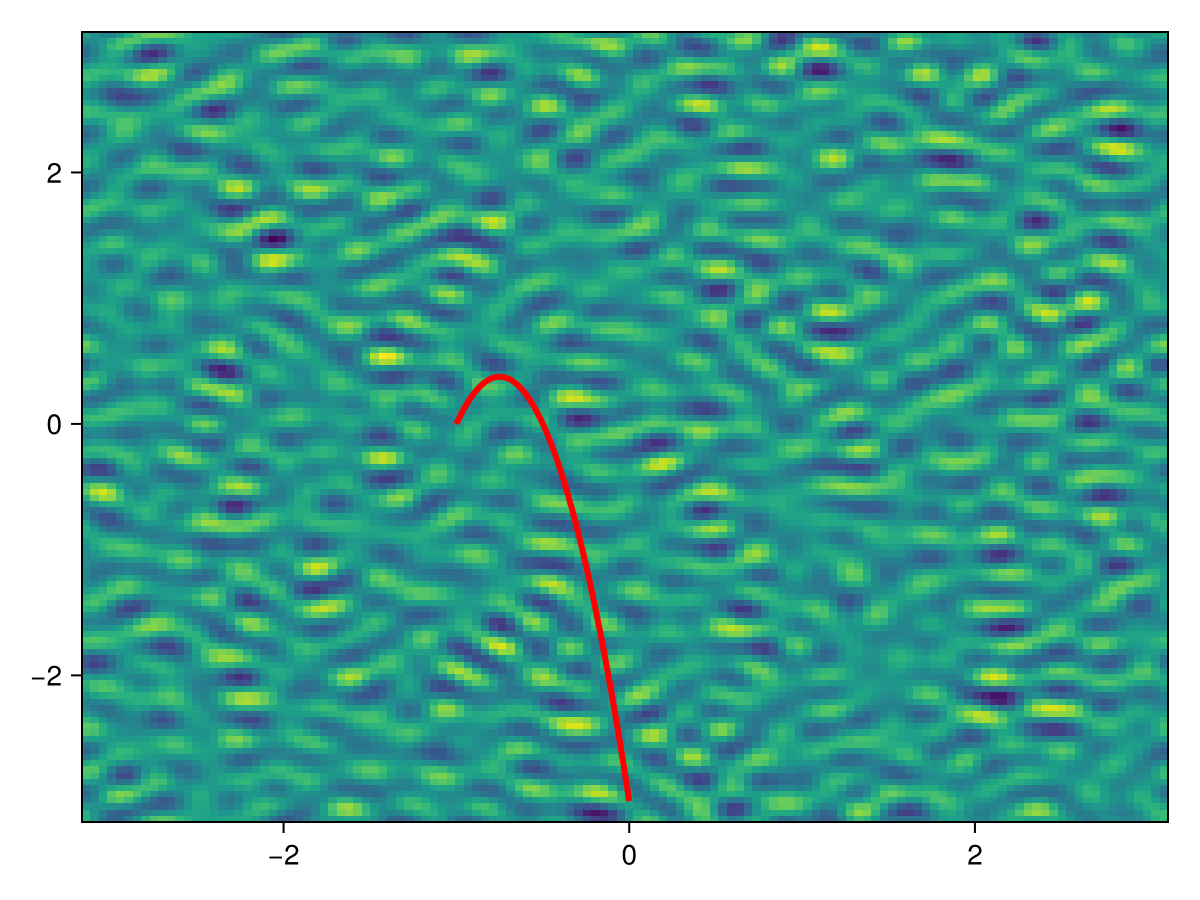

In [140]:
fig = Figure()
ax = Axis(fig[1,1])
N = 128.
t_slice = (0.:1:N) / N
x_query = @. (t_slice - 1)
y_query = @. -6*t_slice^2  + 3*t_slice
heatmap!(ax, grid.x, grid.y, U)
lines!(ax, mod.(x_query.+grid.Lx/2, grid.Lx).-grid.Lx/2, y_query; linewidth=3, color="red")
fig

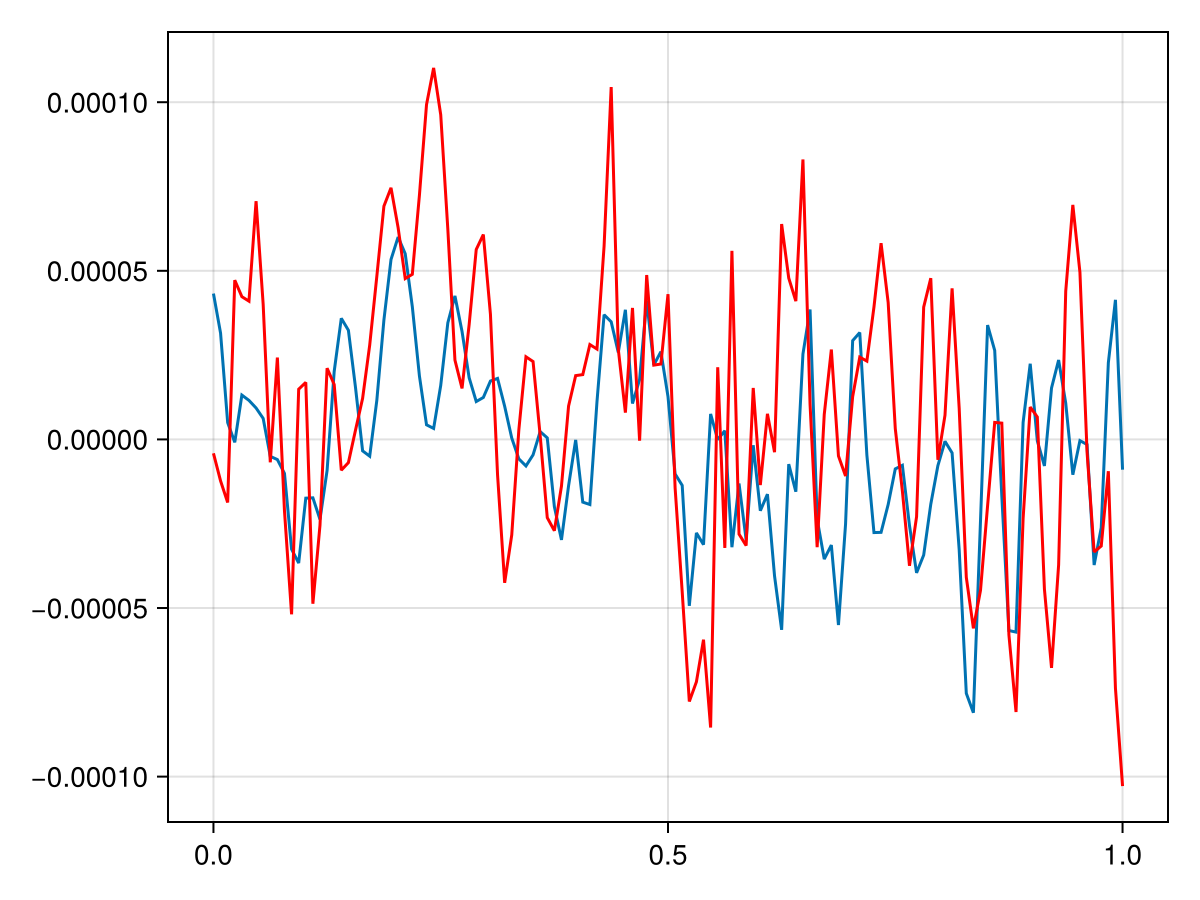

In [141]:
interpolated = ψ_itp.(x_query, y_query)
lanczos_interpolated = func.(x_query, y_query)
exact = ψ_func.(x_query, y_query)
fig = Figure()
ax = Axis(fig[1,1])
#lines!(ax, t_slice, interpolated)
#lines!(ax, t_slice, exact)
lines!(ax, t_slice, (interpolated - exact))
lines!(ax, t_slice, (lanczos_interpolated - exact); color="red")
fig

In [8]:
function dispersion_relation(k, params)
    return sqrt(params.f^2 + params.Cg^2*(k[1]*k[1] + k[2]*k[2]));
end

function group_velocity(k, params)
   return params.Cg^2*k/dispersion_relation(k, params); 
end

function dxdt(xdot, x, k, params, t)
    group_vel = group_velocity(k, params);
    xdot[1] = params.u(x[1], x[2], t) + group_vel[1];
    xdot[2] = params.v(x[1], x[2], t) + group_vel[2];
end

function dkdt(kdot, x, k, params, t);
    kdot[1] = -params.ux(x[1], x[2], t)*k[1] - params.vx(x[1], x[2], t)*k[2];
    kdot[2] = -params.uy(x[1], x[2], t)*k[1] - params.vy(x[1], x[2], t)*k[2];
end

dkdt (generic function with 1 method)

In [49]:
using DifferentialEquations

function stepforward(Npackets::Int, x_hist, k_hist, u_hist, iter, dt::Float64, tspan::Tuple{Float64, Float64}, params)
    for i=1:Npackets
	#for i=1:Npackets
        problem = DynamicalODEProblem(dxdt, dkdt, x_hist[iter,i,:], k_hist[iter,i,:], tspan, params);
        local sim = DifferentialEquations.solve(problem, AutoTsit5(Rosenbrock23()), dt=dt, save_on=false, save_start=false);
        x_hist[iter+1,i,1] = sim[1,1];
		x_hist[iter+1,i,2] = sim[2,1];
		k_hist[iter+1,i,1] = sim[3,1];
		k_hist[iter+1,i,2] = sim[4,1];
		u_hist[iter+1,i,1] = params.u(sim[1,1], sim[2,1], tspan[2])
		u_hist[iter+1,i,2] = params.v(sim[1,1], sim[2,1], tspan[2])
    end
end

stepforward (generic function with 1 method)

In [50]:
using Printf
#u(x,y,t) = U_func(x,y)
#v(x,y,t) = V_func(x,y)
#ux(x,y,t) = Ux_func(x,y)
#uy(x,y,t) = Uy_func(x,y)
#vx(x,y,t) = Vx_func(x,y)
#vy(x,y,t) = Vy_func(x,y)
u(x,y,t)   = u_itp(x,y)
v(x,y,t)   = v_itp(x,y)
ux(x,y,t) = ux_itp(x,y)
uy(x,y,t) = uy_itp(x,y)
vx(x,y,t) = vx_itp(x,y)
vy(x,y,t) = vy_itp(x,y)

timestep = 1e-1
dt = 5e-3
end_time = 150
Nsteps = Int(ceil(end_time/timestep))
frames = 1:Nsteps
Npackets = 36
t_hist = Array{Float64}(undef, 1+length(frames))
x_hist = Array{Float64}(undef, 1+length(frames), Npackets, 2)
k_hist = Array{Float64}(undef, 1+length(frames), Npackets, 2)
u_hist = Array{Float64}(undef, 1+length(frames), Npackets, 2)
t_hist[1] = 0
@Threads.threads for i = 1:Npackets
    x_hist[1, i, 1] = 2*π*i/Npackets
    x_hist[1, i, 2] = 0
    k_hist[1, i, 1] = cos(2*π*i/Npackets)
    k_hist[1, i, 2] = sin(2*π*i/Npackets)
    u_hist[1, i, 1] = u(x_hist[1,i,1], x_hist[1,i,2],0)
    u_hist[1, i, 2] = v(x_hist[1,i,1], x_hist[1,i,2],0)
end

t = 0.
startwalltime = time()

packet_params = (f = 1, Cg = 1, u=u, v=v, ux=ux, vx=vx, uy=uy, vy=vy)
for j=frames
    if (j % (100) == 0)
        log = @sprintf("step: %04d, t: %.1f, walltime: %.2f min",
                       j, t, (time()-startwalltime)/60)
        println(log)
    end
    new_t = t + timestep;
    stepforward(Npackets, x_hist, k_hist, u_hist, j, dt, (t, new_t), packet_params);
    t_hist[j+1] = new_t
    # stepraysforward!(grid, packets, old_v, new_v, (old_t / packet_params.packetVelocityScale, new_t / packet_params.packetVelocityScale), packet_params);
    t = new_t;
    # savepackets!(out, clock, packets); # Save with latest velocity information
end

step: 0100, t: 9.9, walltime: 0.22 min
step: 0200, t: 19.9, walltime: 0.23 min
step: 0300, t: 29.9, walltime: 0.24 min
step: 0400, t: 39.9, walltime: 0.25 min
step: 0500, t: 49.9, walltime: 0.26 min
step: 0600, t: 59.9, walltime: 0.26 min
step: 0700, t: 69.9, walltime: 0.27 min
step: 0800, t: 79.9, walltime: 0.28 min
step: 0900, t: 89.9, walltime: 0.29 min
step: 1000, t: 99.9, walltime: 0.30 min
step: 1100, t: 109.9, walltime: 0.31 min
step: 1200, t: 119.9, walltime: 0.32 min
step: 1300, t: 129.9, walltime: 0.33 min
step: 1400, t: 139.9, walltime: 0.34 min
step: 1500, t: 149.9, walltime: 0.34 min


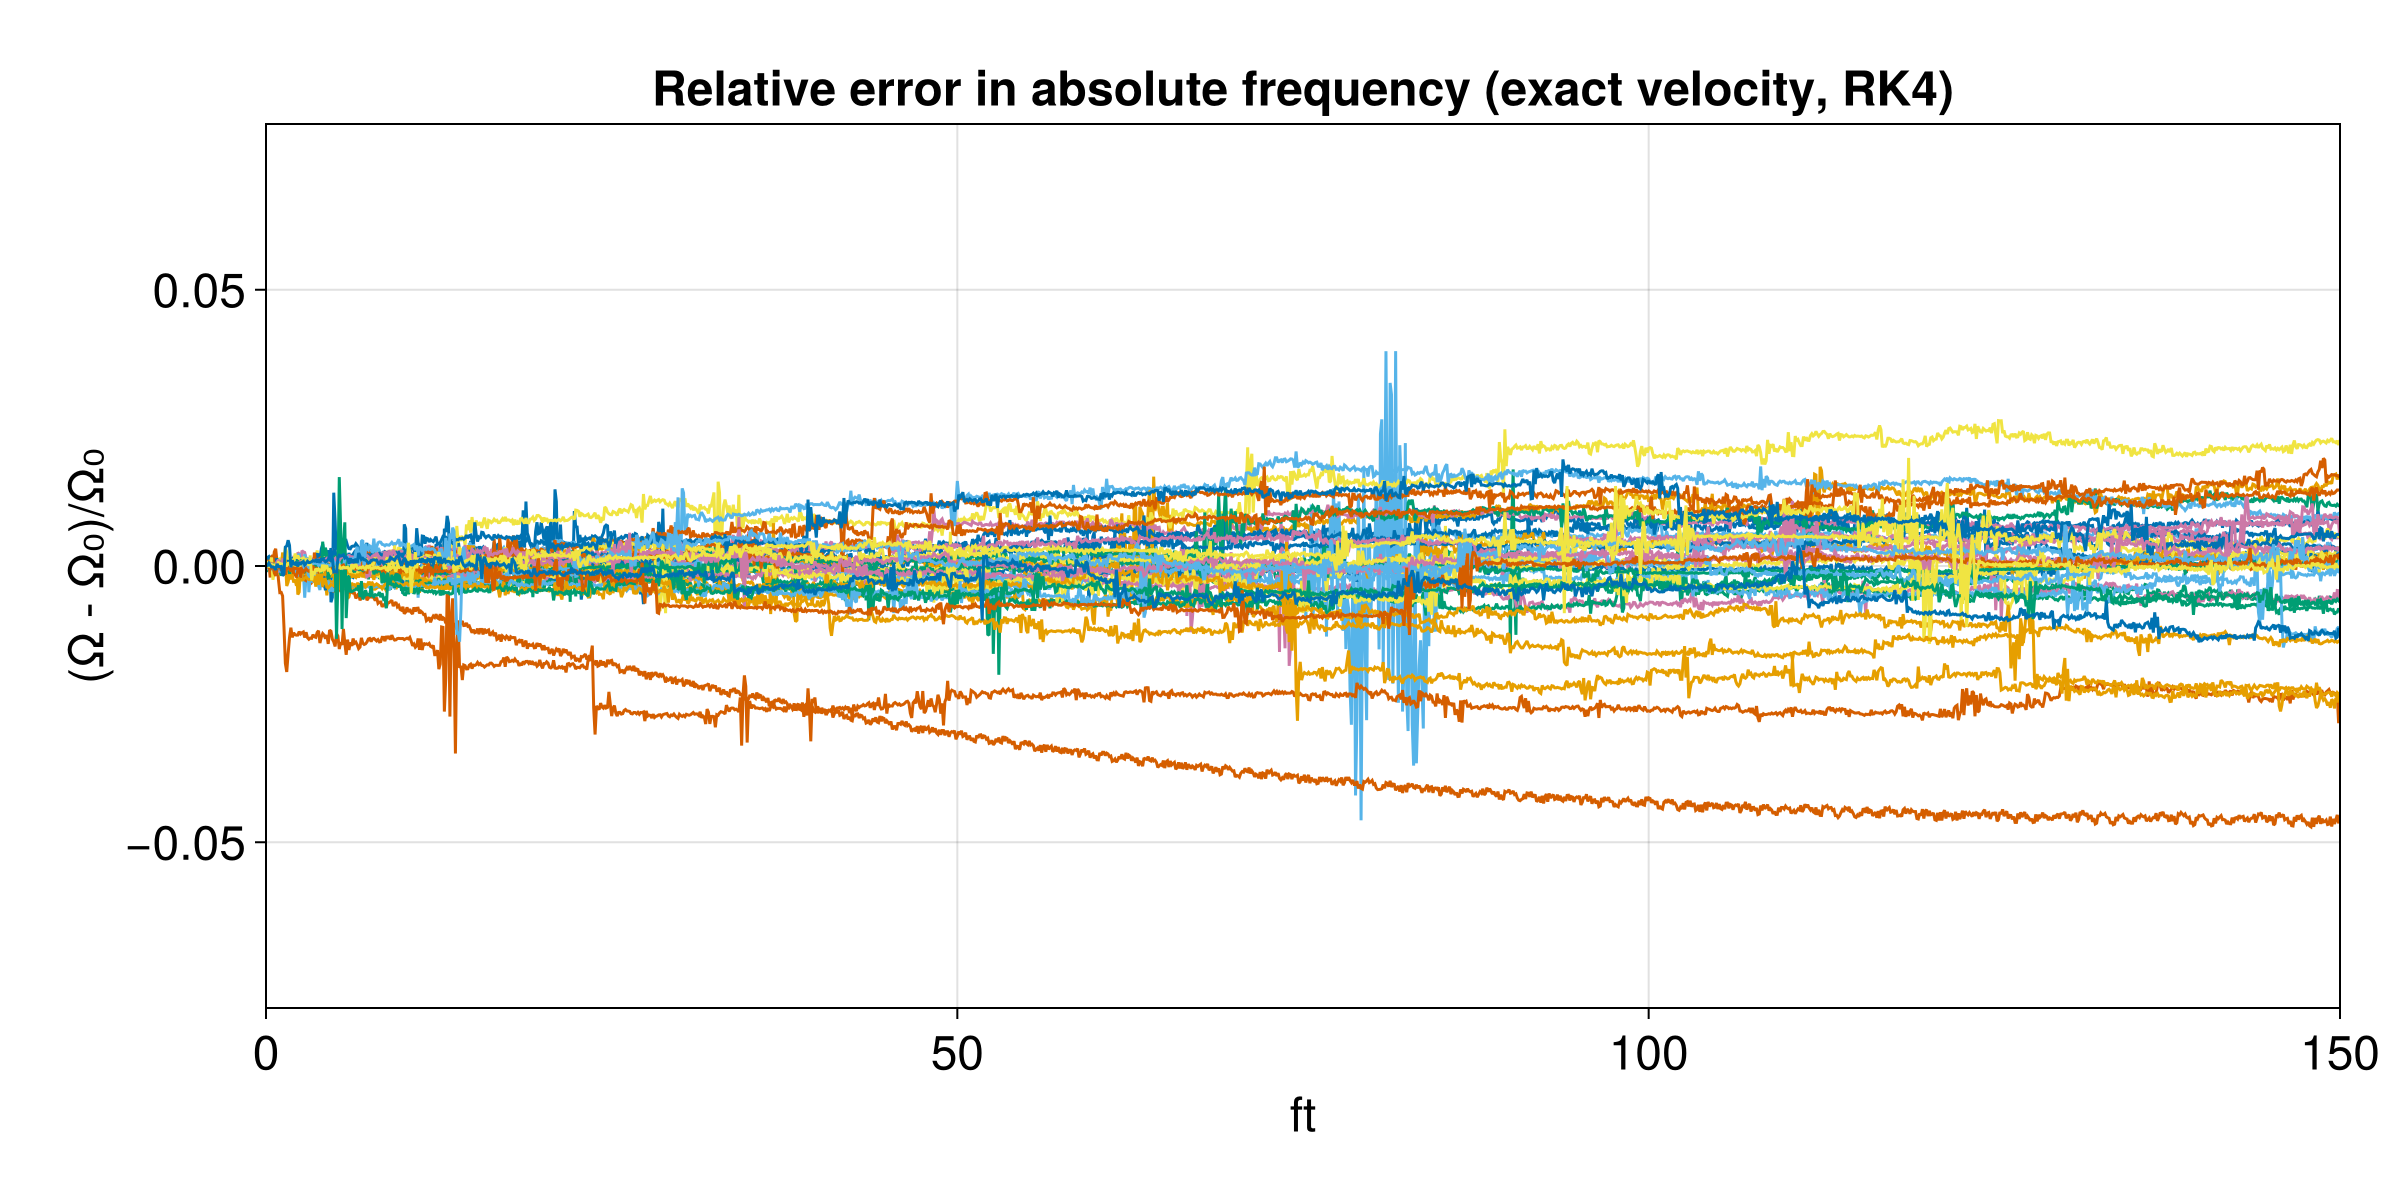

In [51]:
fig = Figure(size=(1200, 600), fontsize = 24, figure_padding = 30)
ax = Axis(fig[1, 1]; 
        title = "Relative error in absolute frequency (interpolated, implicit)", xlabel="ft", ylabel="(Ω - Ω₀)/Ω₀",
        limits = ((0, maximum(t_hist)), (-8e-2, 8e-2))
)
ω = sqrt.(packet_params.f^2 .+ packet_params.Cg^2*sum(k_hist .* k_hist, dims=3))
Ω = sum(u_hist .* k_hist, dims=3) + ω
for i=1:Npackets
    lines!(ax, t_hist, (Ω[:,i,1] .- Ω[1,i,1])/Ω[1,i,1])
end

fig

In [13]:
size(Ω)

(1501, 36, 1)

In [99]:
u_hist

11×1×2 Array{Float64, 3}:
[:, :, 1] =
  0.17114388980731415
 -0.32927111798775044
 -0.33942610348793734
  0.0835714299708633
 -0.13204910848511522
  0.15614325008402477
  0.006947406680205768
  0.118375977518772
 -0.3966677022585968
 -0.033878949812041925
 -0.34080504750259755

[:, :, 2] =
 -0.3274611561297631
  0.34916020183769564
 -0.47930722857567676
  0.2742231167066078
 -0.7472941821008238
  0.3993173089841434
 -0.2207607203895938
 -0.01956124160290392
  0.3590577151293631
 -0.13877968129454654
 -0.0782795499015492